## Load Libraies

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import torch 
import torch.nn as nn
from torchvision import datasets , models , transforms
from torch.utils.data import DataLoader
from torch.nn import functional as F
import torch.optim as optim 
from tqdm import tqdm
from PIL import Image
from torch.cuda.amp import GradScaler, autocast

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
input_path = "Flower_Classification"
train_dir = input_path + '/train'
valid_dir = input_path + '/valid'

In [11]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'valid':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ]),
}


image_datasets = {
    'train': 
    datasets.ImageFolder(train_dir , data_transforms['train']),
    'valid': 
    datasets.ImageFolder(valid_dir , data_transforms['valid'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=0),
    'valid':
    torch.utils.data.DataLoader(image_datasets['valid'],
                                batch_size=32,
                                shuffle=False,
                                num_workers=0)
}

In [12]:
model = models.resnet50(pretrained=True)

In [13]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
# setup to pick up GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# freeze parameters - to prevent gradients and backprop
for param in model.parameters():
    param.requires_grad = False

classifier = nn.Sequential(nn.Linear(2048, 500),
                           nn.ReLU(),
                           nn.Dropout(p=0.2),
                           nn.Linear(500,2),
                           nn.Softmax(dim=1)
                          )
model.fc = classifier



optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()



model.to(device)

scaler = GradScaler()

In [15]:
# Train the model
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    running_loss = 0.0
    running_corrects = 0.0
    model.train()
    for inputs,labels in tqdm(dataloaders['train']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(image_datasets['train'])
    epoch_acc = running_corrects.double() / len(image_datasets['train'])

    print('{} loss: {:.4f}, acc: {:.4f}'.format('Train',
                                                epoch_loss,
                                                epoch_acc))


    running_loss = 0.0
    running_corrects = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs,1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(image_datasets['valid'])
        epoch_acc = running_corrects.double() / len(image_datasets['valid'])

        print('{} loss: {:.4f}, acc: {:.4f}'.format('Valid',
                                                    epoch_loss,
                                                    epoch_acc))
        

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:33<00:00,  6.05it/s]


Train loss: 0.4280, acc: 0.8798


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.75it/s]


Valid loss: 0.4087, acc: 0.9011


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:30<00:00,  6.47it/s]


Train loss: 0.4010, acc: 0.9078


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.13it/s]


Valid loss: 0.3848, acc: 0.9286


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:31<00:00,  6.37it/s]


Train loss: 0.3981, acc: 0.9118


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.15it/s]


Valid loss: 0.3747, acc: 0.9368


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.22it/s]


Train loss: 0.3844, acc: 0.9264


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.09it/s]


Valid loss: 0.3795, acc: 0.9368


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:31<00:00,  6.43it/s]


Train loss: 0.3973, acc: 0.9120


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.10it/s]


Valid loss: 0.4218, acc: 0.8819


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:30<00:00,  6.48it/s]


Train loss: 0.4027, acc: 0.9085


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.58it/s]


Valid loss: 0.3779, acc: 0.9341


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:30<00:00,  6.60it/s]


Train loss: 0.3963, acc: 0.9140


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.43it/s]


Valid loss: 0.3731, acc: 0.9396


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:30<00:00,  6.55it/s]


Train loss: 0.3918, acc: 0.9192


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.65it/s]


Valid loss: 0.3692, acc: 0.9423


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.19it/s]


Train loss: 0.3833, acc: 0.9278


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.66it/s]


Valid loss: 0.3793, acc: 0.9286


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.21it/s]


Train loss: 0.3950, acc: 0.9158


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.73it/s]

Valid loss: 0.4637, acc: 0.8462


In [ ]:
test_data = datasets.ImageFolder(input_path + "/test_image" , data_transfroms['valid'])


test_loader = torch.utils.data.DataLoader(test_dataset , batch_size=1)


In [16]:
validation_img_paths = ["/test/daisy/1392131677_116ec04751_jpg.rf.83705c503f603f283a0ee2dd2adc9cf4.jpg",
                        "/test/daisy/14866200659_6462c723cb_m_jpg.rf.da00a8b41ad8f62b313964fb4969946b.jpg",
                        "/test/dandelion/14060367700_fe87e99b6a_m_jpg.rf.638675b2755816d9892321733c501a49.jpg"]
img_list = [Image.open(input_path + img_path) for img_path in validation_img_paths]

In [17]:
test_batch = torch.stack([data_transforms['valid'](img).to(device)
                                for img in img_list])

In [18]:
pred = model(test_batch)
pred

tensor([[1.0000e+00, 1.1945e-35],
        [1.0000e+00, 6.1638e-27],
        [2.4820e-12, 1.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

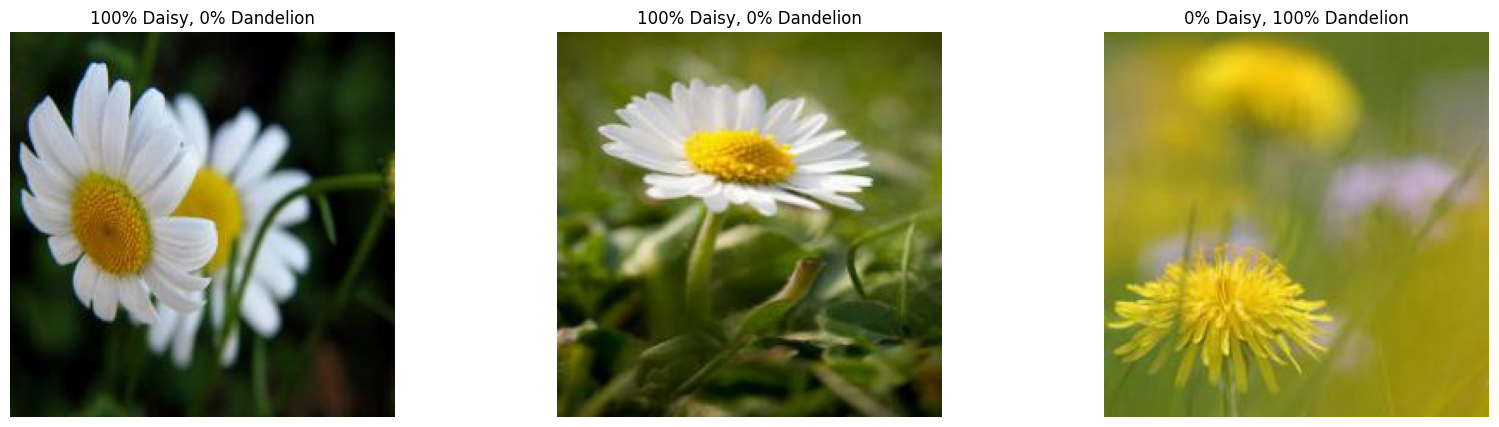

In [19]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Daisy, {:.0f}% Dandelion".format(100*pred[i,0],
                                                            100*pred[i,1]))
    ax.imshow(img)

In [20]:
!mkdir model_py
!mkdir model_py/pytorch_2

In [21]:
# Save the trained model
torch.save(model.state_dict(), 'model_py/pytorch_2/flower_classification_resnet50.pth')